In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/competitions/aptos2019-blindness-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sharmasanyam
Your Kaggle Key: ··········


100%|██████████| 9.51G/9.51G [09:23<00:00, 18.1MB/s]



Extracting archive ./aptos2019-blindness-detection/aptos2019-blindness-detection.zip to ./aptos2019-blindness-detection


In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 22.7 MB/s eta 0:00:00


In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import timm

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

from sklearn.metrics import confusion_matrix

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm, tqdm_notebook
import os, random
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle
import torch

!ls ../content/*

../content/aptos2019-blindness-detection:
sample_submission.csv  test.csv  test_images  train.csv  train_images

../content/sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
import fastai
from fastai import *
from fastai.data import *
from fastai.vision import *
from fastai.vision.all import *

from fastai.vision.learner import *

fastai.__version__

'2.7.12'

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

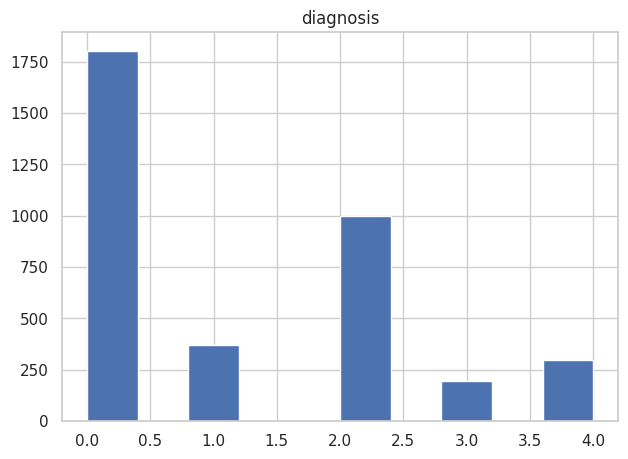

In [ ]:
from pathlib import Path
PATH = Path('../content/aptos2019-blindness-detection')

df_train = pd.read_csv(PATH/'train.csv')
df_test = pd.read_csv(PATH/'test.csv')

# if is_interactive():
#     df_train = df_train.sample(800)

_ = df_train.hist()

In [ ]:
aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])
df_train['id_code'] = df_train['id_code'].apply(lambda x: x + '.png')
dls = ImageDataLoaders.from_df(df_train, 
                               path=PATH, folder='train_images',
                               valid_pct=0.1, seed=42,
                               item_tfms=Resize(224, method='pad', pad_mode='zeros'),
                               batch_tfms=[*aug_transforms(flip_vert=True, max_warp=0.1, max_zoom=1.15, max_rotate=45.), Normalize.from_stats(*aptos19_stats)],
                               bs=32, 
                               num_workers=os.cpu_count())

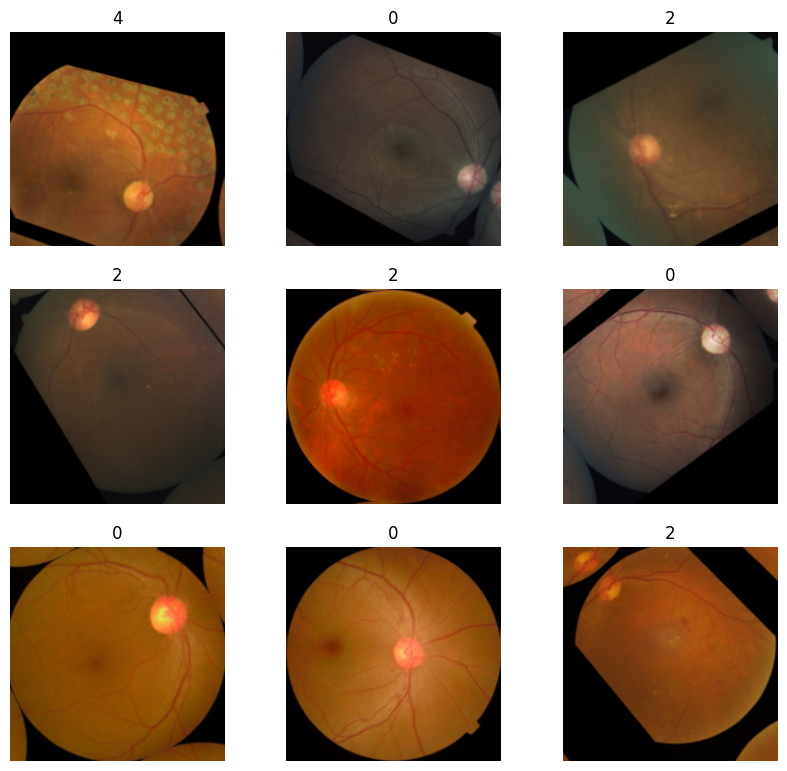

In [ ]:
dls.show_batch()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [ ]:
def run_models(model_type,out_cnt,loss,metric,train_time=10):
    learn = cnn_learner(dls,
                      model_type,
                      pretrained=True,
                      loss_func=loss, # focalloss(),
                      metrics=metric, # [accuracy,RocAuc()],
                      n_out=out_cnt
                      )
#     learn.model[-1][-1] = nn.Linear(in_features=learn.model[-1][-1].in_features, out_features=out_cnt, bias=True)
    print("total epoch ",train_time)
    learn.fine_tune(train_time)

In [ ]:
pcpvt_learn=run_models('twins_pcpvt_base',5,FocalLoss(),[accuracy,RocAuc()])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vt3p-weights/twins_pcpvt_base-e5ecb09b.pth" to /root/.cache/torch/hub/checkpoints/twins_pcpvt_base-e5ecb09b.pth


total epoch  10


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.024560,0.459628,0.696721,0.862210,07:16


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.608572,0.270228,0.778689,0.905093,07:56
1,0.497298,0.234036,0.825137,0.919385,08:08
2,0.400472,0.213389,0.816940,0.934130,08:03
3,0.309870,0.191963,0.827869,0.930874,08:01
4,0.253884,0.165438,0.849727,0.950431,08:00
5,0.222920,0.160628,0.863388,0.951450,07:58
6,0.202036,0.149798,0.852459,0.950708,08:02
7,0.174917,0.153064,0.866120,0.948635,08:02
8,0.175518,0.147283,0.866120,0.951501,07:58
9,0.165467,0.147616,0.868852,0.952359,08:02


In [ ]:
run_models('efficientnet_b0',5,FocalLoss(),[accuracy,RocAuc()])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


total epoch  10


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.185997,0.684567,0.726776,0.843959,07:42


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.707175,0.435211,0.762295,0.860671,07:46
1,0.606831,0.398210,0.734973,0.885412,07:47
2,0.503416,0.291728,0.775956,0.898360,07:46
3,0.419061,0.245831,0.784153,0.913677,07:43
4,0.358838,0.219252,0.781421,0.913689,07:46
5,0.296171,0.226623,0.778689,0.919902,07:48
6,0.281851,0.198989,0.773224,0.924229,07:50
7,0.260965,0.198922,0.770492,0.924177,07:46
8,0.250559,0.187770,0.795082,0.928548,07:42
9,0.232118,0.201058,0.786885,0.927132,07:43


In [ ]:
run_models('darknet53',5,FocalLoss(),[accuracy,RocAuc()])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/darknet53_256_c2ns-3aeff817.pth" to /root/.cache/torch/hub/checkpoints/darknet53_256_c2ns-3aeff817.pth


total epoch  10


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.115446,0.725976,0.710383,0.855389,07:00


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.766030,0.576834,0.724044,0.892360,07:02
1,0.656363,0.475306,0.745902,0.907794,07:01
2,0.553161,0.355274,0.784153,0.911271,07:02
3,0.421323,0.299615,0.770492,0.918359,07:05
4,0.360894,0.233992,0.822404,0.925831,07:08
5,0.313419,0.234072,0.806011,0.929742,07:05
6,0.279741,0.205020,0.816940,0.934998,07:09
7,0.259461,0.206347,0.822404,0.935037,07:03
8,0.254884,0.205520,0.814208,0.937332,07:01
9,0.247809,0.199524,0.825137,0.939176,07:03


In [ ]:
run_models('inception_v3',5,FocalLoss(),[accuracy,RocAuc()])

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


total epoch  10


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.224190,0.659245,0.773224,0.866049,06:51


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.799146,0.450487,0.765027,0.895360,06:56
1,0.665336,0.386272,0.775956,0.866529,06:58
2,0.514937,0.323472,0.781421,0.881241,06:56
3,0.419187,0.275891,0.778689,0.896300,06:56
4,0.353406,0.238708,0.786885,0.891288,06:55
5,0.309595,0.208134,0.822404,0.916723,06:57
6,0.289847,0.206200,0.816940,0.912625,06:58
7,0.292296,0.196967,0.827869,0.919092,06:59
8,0.258617,0.201891,0.816940,0.917528,06:58
9,0.255539,0.196558,0.830601,0.915547,07:00


In [ ]:
run_models('inception_v4',5,FocalLoss(),[accuracy,RocAuc()])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


total epoch  10


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.172684,0.745687,0.724044,0.846419,07:14


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.762275,0.477390,0.737705,0.879231,07:55
1,0.707554,0.406705,0.737705,0.870721,08:00
2,0.545134,0.345807,0.765027,0.889981,07:57
3,0.418969,0.265199,0.795082,0.913130,07:59
4,0.356519,0.267321,0.792350,0.916565,08:00
5,0.309155,0.204397,0.836066,0.928262,08:00
6,0.280811,0.198268,0.797814,0.930249,08:01
7,0.245954,0.179718,0.833333,0.937770,07:55
8,0.237157,0.182430,0.808743,0.934963,07:58
9,0.226772,0.187592,0.806011,0.934067,07:56
